# Import model and create animations

In [175]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from architectures import COTGAN
import neptune.new as neptune
from utils import restore_weights

"""
591 - BEST SO FAR, Soliton
600 - BEST SO FAR, colliding solitons

592 - newest with everything correct
541 - good two solitons
442 - good, sinkhorn_l=200
437 - good
407 - lowest H_mean_loss
405 - decent
401 - mode collapse
400 - decent
399 - epochs: 300
"""

model_id = "COT-591"

run = neptune.init_run(
                with_id=model_id, # "TIMEGAN-84"
                project="kohmann/COTGAN",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI3YjFjNGY5MS1kOWU1LTRmZjgtOTNiYS0yOGI2NDdjZGYzNWUifQ==",)
params = run["parameters"].fetch()
params["device"] = "cpu"

model = COTGAN(params)
model = restore_weights(model, run)
model

https://app.neptune.ai/kohmann/COTGAN/e/COT-591
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.
Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 4 operations to synchronize with Neptune. Do not kill this process.
All 4 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/kohmann/COTGAN/e/COT-591


COTGAN(
  (generator): SolitonGenerator(
    (gen_rnn): GRU(10, 64, batch_first=True)
    (gen_rnn2): GRU(64, 128, batch_first=True)
    (gen_FC): Sequential(
      (0): Linear(in_features=128, out_features=64, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
      (4): Linear(in_features=64, out_features=120, bias=True)
      (5): Sigmoid()
    )
  )
  (discriminator_h): SolitonDiscriminator(
    (dis_cnn): Sequential(
      (0): Conv1d(1, 64, kernel_size=(5,), stride=(1,), padding=same)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Conv1d(64, 128, kernel_size=(5,), stride=(1,), padding=same)
      (3): LeakyReLU(negative_slope=0.01)
    )
    (dis_rnn): GRU(15360, 64, batch_first=True)
    (dis_rnn_2): GRU(64, 32, batch_first=True)
  )
  (discriminator_m): SolitonDiscriminator(
    (dis_cnn): Sequential(
      (0): Conv1d(1, 64, kernel_size=(5,), stride=(1,), padding=sam

In [176]:
# Generate samples
n_samples = params["trainset_size"]
fake = model.generate(n_samples)
fake.shape

torch.Size([1920, 30, 120])

In [177]:
batch_nr = 3

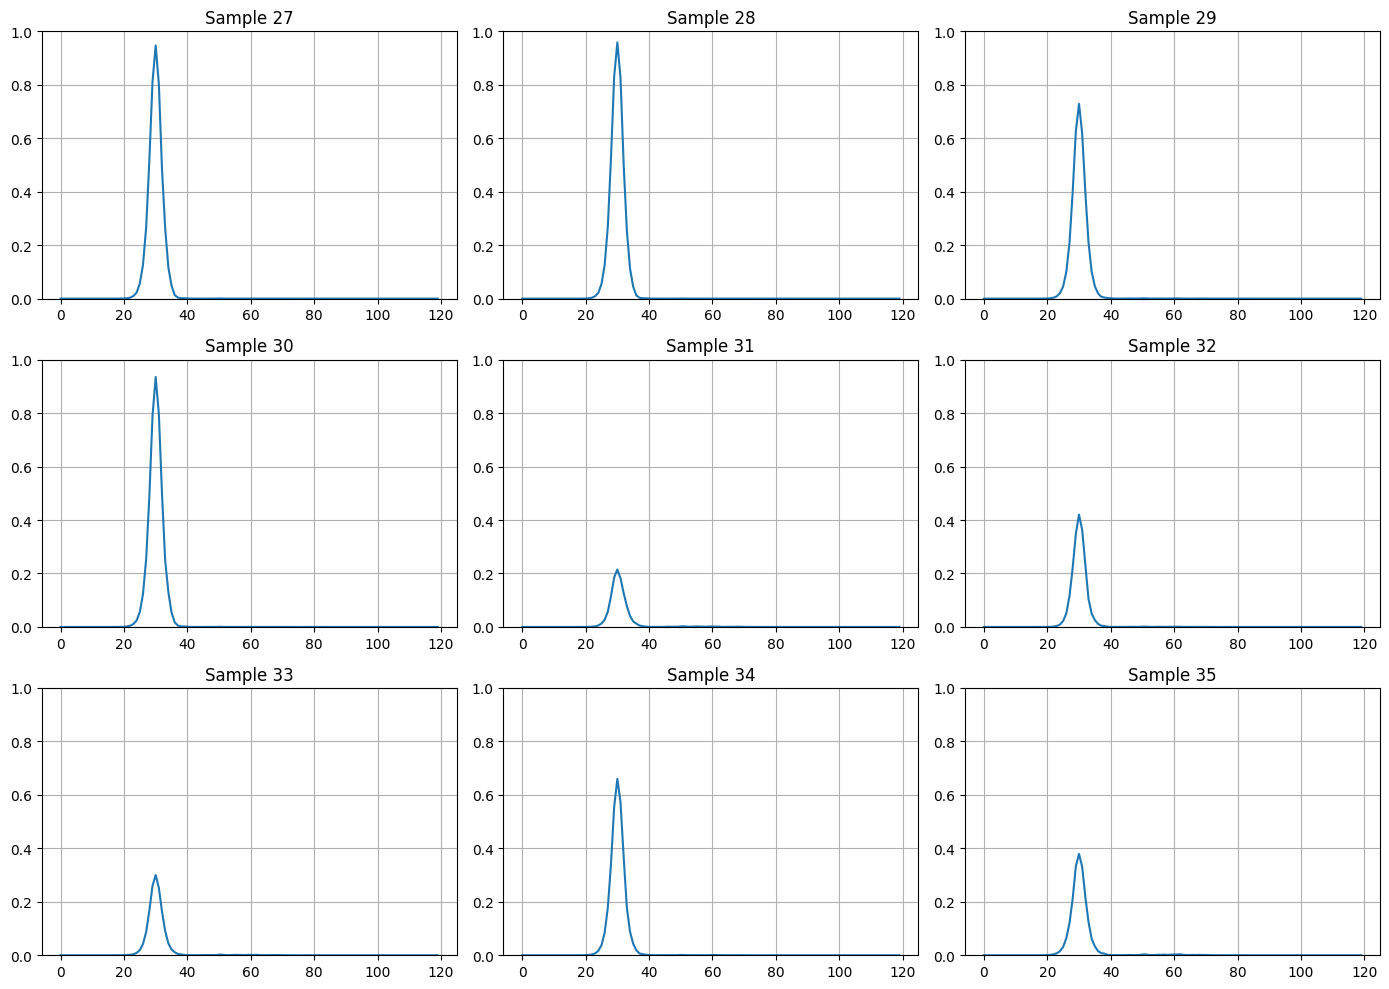

In [178]:
def plot_batch(data, batch_nr):
    start_idx = batch_nr*9
    fig, axs = plt.subplots(3, 3, figsize=(14, 10))
    for ax in axs.flat:
        ax.set_ylim((0, 1))
        ax.grid()
    for i in range(3):
        for j in range(3):
            idx = start_idx + i*3+j
            axs[i, j].plot(data[idx, 0].T)
            axs[i, j].set_title(f"Sample {idx}")

            fig.tight_layout()
plot_batch(fake, batch_nr=batch_nr)

MovieWriter ffmpeg unavailable; using Pillow instead.


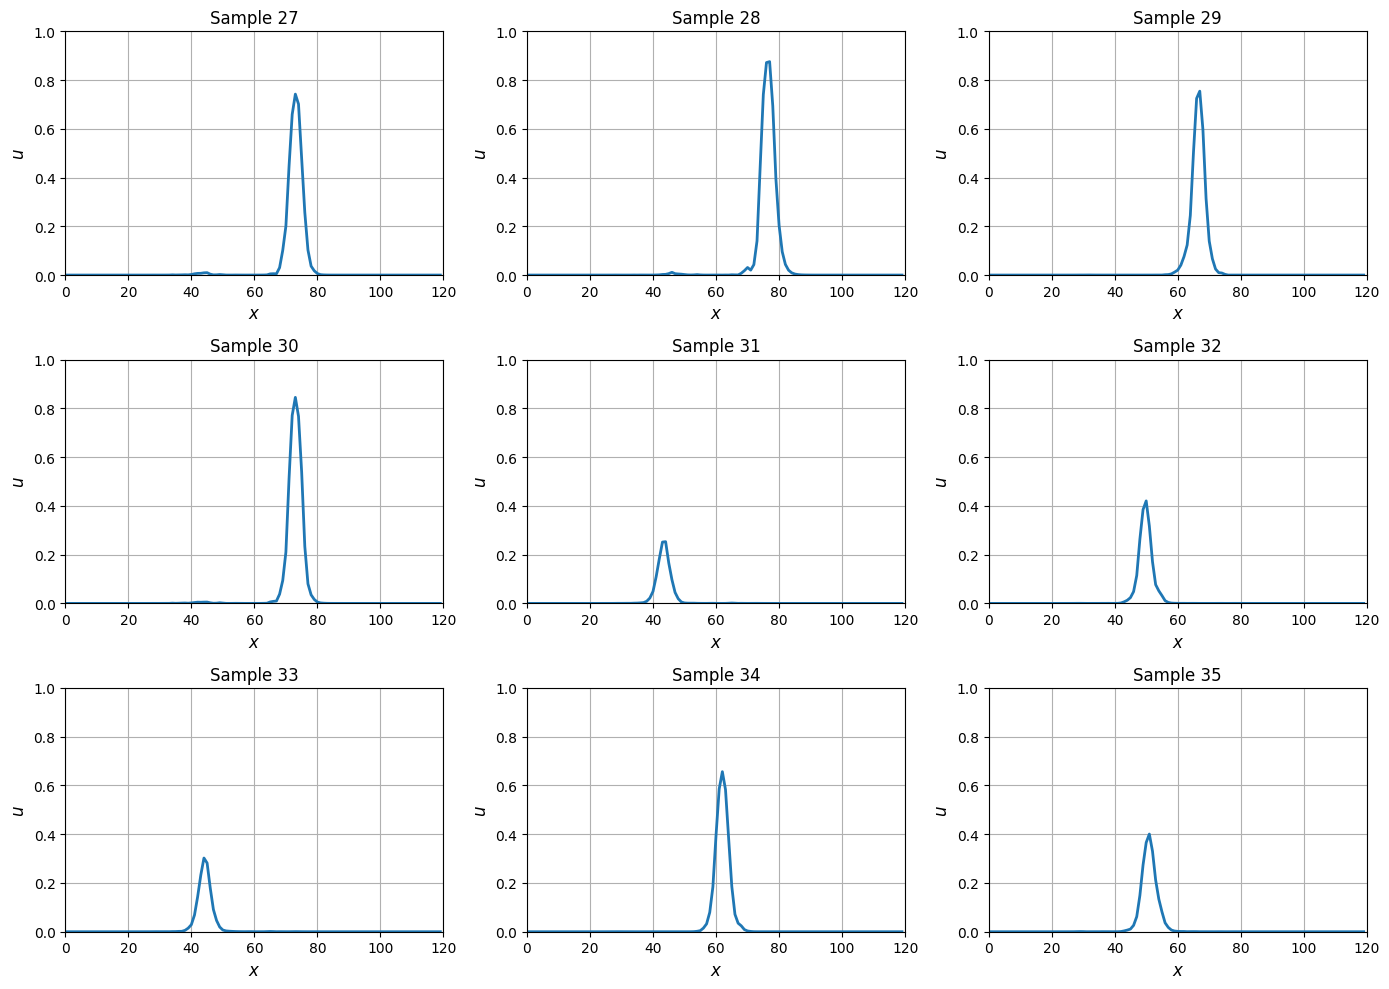

In [180]:
def animate_batch(data, batch_nr, title="soliton_batch"):
    batch_idx = batch_nr * 9
    rc('animation', html='jshtml')
    # create a figure with two subplots
    fig, axes = plt.subplots(3,3,  figsize=(14, 10))

    for i, ax in enumerate(axes.flat):
        ax.set_xlim((0, data.shape[2]))
        ax.set_ylim((0, 1))
        ax.set_xlabel('$x$', fontsize=12)
        ax.set_ylabel('$u$', fontsize=12)
        ax.set_title(f"Sample {batch_idx + i}")
        ax.grid()

    # init lines and axes
    lines = []
    for i, ax in enumerate(axes.flat):
        line_sub, = ax.plot([], [], lw=2)
        lines.append(line_sub)

    x = np.arange(data.shape[2])

    def init():
        for line in lines:
            line.set_data([], [])
        return lines
    # initialize the data arrays

    def animate(i):
        # update the data of both line objects
        for j, line in enumerate(lines):
            line.set_data(x, data[batch_idx + j, i])
        return lines

    ani = animation.FuncAnimation(fig, animate, init_func=init,
                                      frames=data.shape[1], interval=20, blit=True)
    fig.tight_layout()
    ani.save("plots/" + title + '.gif', fps=15)

    plt.show()

animate_batch(fake, batch_nr=batch_nr)

In [181]:
single_example_nr = 35

MovieWriter ffmpeg unavailable; using Pillow instead.


Mean H: 0.0243383701890707, H_max: 0.046625375747680664


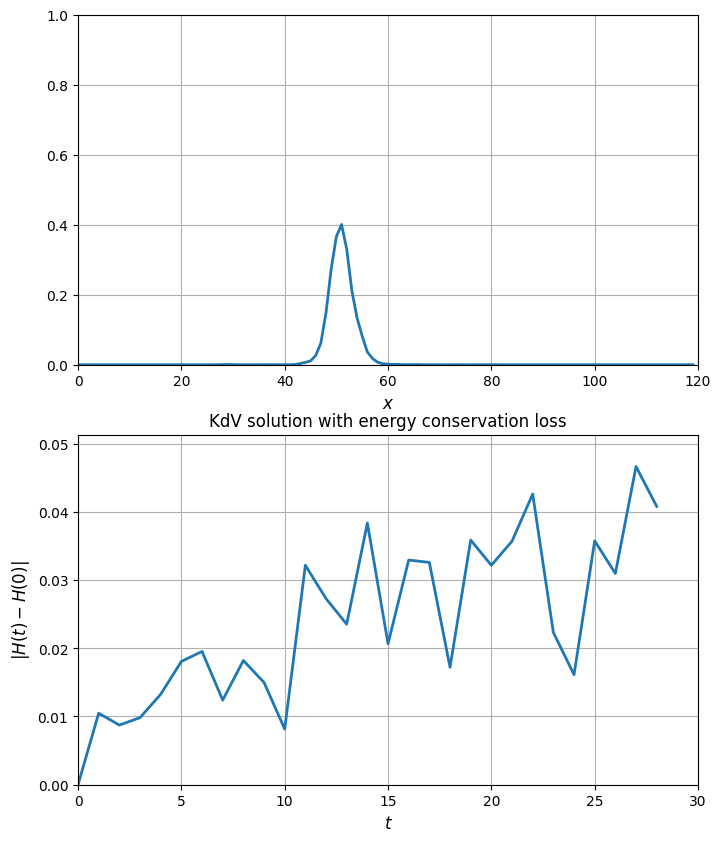

In [189]:
from metrics import energy_conservation, mass_conservation, momentum_conservation
def animate_single_w_energy(data, title, params, fps=10, energy_type="total"):
    rc('animation', html='jshtml')
    fig, ax = plt.subplots(2,1, figsize=(8, 10))
    plt.title(title)
    line1, = ax[0].plot([], [], lw=2)
    line2, = ax[1].plot([], [], lw=2)
    lines = [line1, line2]
    dx = params["P"] / params["spatial_len"]
    if energy_type == "momentum":
        H = momentum_conservation(data[None,:], dx)[0]
    elif energy_type == "mass":
        H = mass_conservation(data[None,:], dx)[0]
    else: # total energy
        energy_type = "energy"
        H = energy_conservation(data[None,:], dx, params["eta"], params["gamma"])[0]
    print(f"Mean H: {H.mean()}, H_max: {H.max()}")
    for i in range(2):
        if i == 0:
            ax[i].set_ylim((0, 1))
            ax[i].set_xlabel('$x$', fontsize=12)
            ax[i].set_xlim((0, data.shape[-1]))
        else:
            ax[i].set_xlabel('$t$', fontsize=12)
            ax[i].set_ylabel('$|H(t) - H(0)|$', fontsize=12)
            ax[i].set_xlim((0, data.shape[0]))
            ax[i].set_ylim((0, H.max()*1.1))
        ax[i].grid()
    x = np.arange(data.shape[1])
    def init():
        lines[0].set_data([], [])
        lines[1].set_data([], [])
        return lines
    def animate(i):
        lines[0].set_data(x, data[i,:])
        lines[1].set_data(np.arange(i), H[:i] - H[0])
        return lines
    ani = animation.FuncAnimation(fig, animate, init_func=init,
                                  frames=data.shape[0], interval=20, blit=True)
    ani.save('plots/soliton_single.gif', fps=fps)

energy_type = "momentum"
ani = animate_single_w_energy(fake[single_example_nr], f"KdV solution with {energy_type} conservation loss", params, fps=15, energy_type=energy_type)

colro: (0.2298057, 0.298717966, 0.753683153, 1.0)
colro: (0.2298057, 0.298717966, 0.753683153, 1.0)
colro: (0.2298057, 0.298717966, 0.753683153, 1.0)
colro: (0.2298057, 0.298717966, 0.753683153, 1.0)
colro: (0.2298057, 0.298717966, 0.753683153, 1.0)
colro: (0.2298057, 0.298717966, 0.753683153, 1.0)
colro: (0.2298057, 0.298717966, 0.753683153, 1.0)
colro: (0.2298057, 0.298717966, 0.753683153, 1.0)
colro: (0.2298057, 0.298717966, 0.753683153, 1.0)
colro: (0.2298057, 0.298717966, 0.753683153, 1.0)


/var/folders/wb/p5xwlpld3rbb00y719123mvr0000gn/T/ipykernel_902/156753162.py:36: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


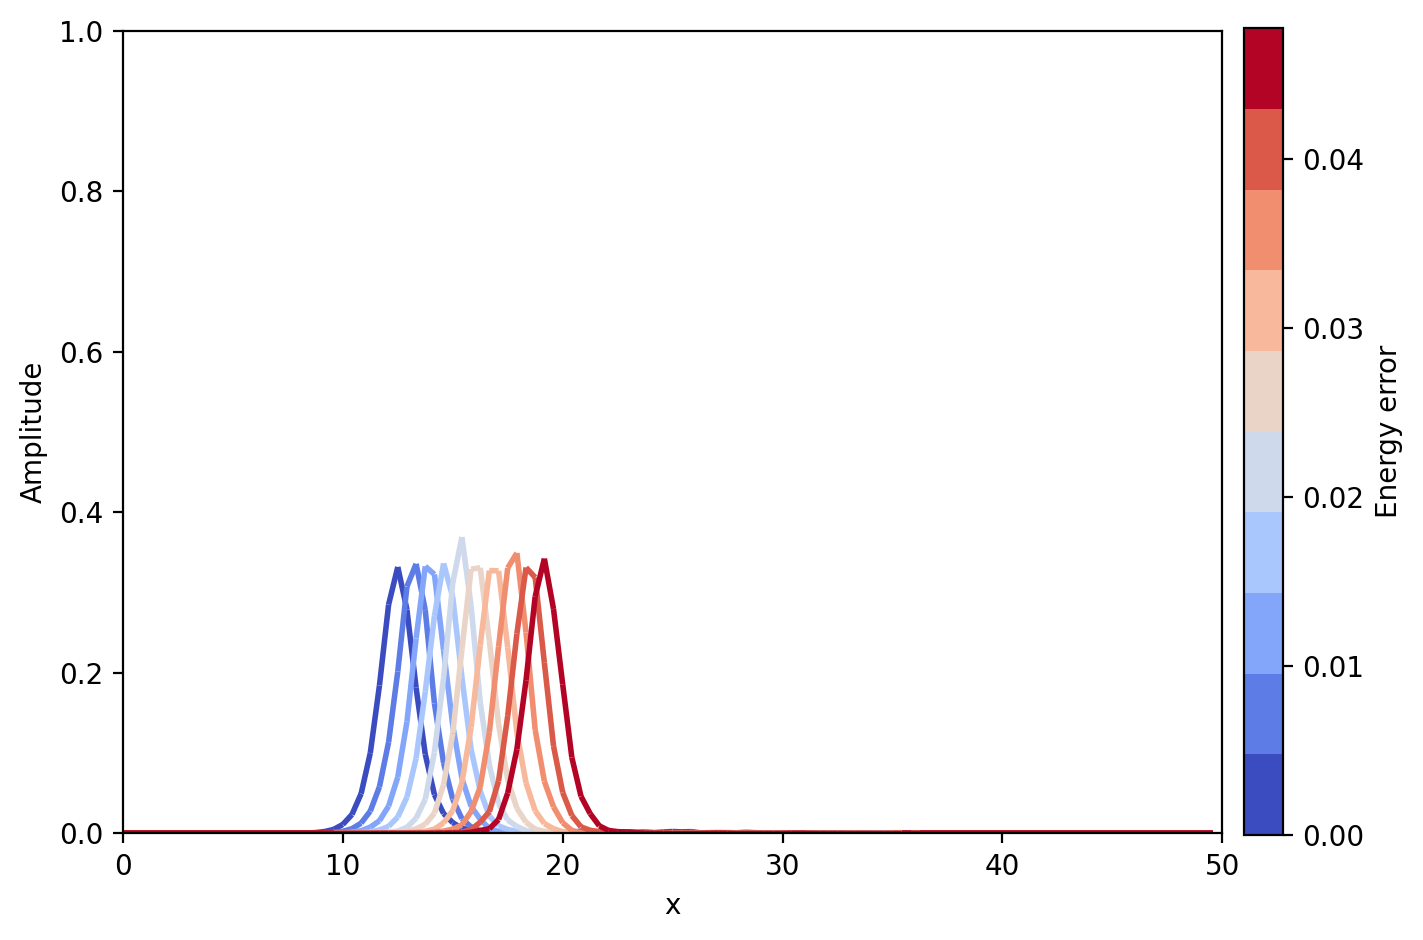

In [202]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot, cm
from matplotlib.collections import LineCollection
def plot_sample_oneplot(sample, dt_step=1, dx=50/120):

    time_steps, x_dim = sample.shape
    # Define the time range and the frequencies of the waves
    x = np.linspace(0, 50-50/x_dim, x_dim)
    H = mass_conservation(sample[None,:], dx)[0]
    sample = sample[::dt_step]
    sample_H = H[::dt_step]
    # Create LineCollection for each wave with a single color
    lines = []
    colors = cm.get_cmap('coolwarm', len(sample))

    for i, wave in enumerate(sample):
        segments = [np.column_stack([x[i:i+2], wave[i:i+2]]) for i in range(len(x) - 1)]
        print(f"colro: {colors(sample_H[i].item())}")
        lc = LineCollection(segments, colors=colors(i), linewidth=2)
        lines.append(lc)

    # Plot all LineCollections on the same axes
    fig, ax = plt.subplots( dpi=200)
    ax.axis([0,50,0,1]) #set axis limits. This is [xlow, xhigh, ylow, yhigh]

    for lc in lines:
        line = ax.add_collection(lc)

    # Add labels and title
    plt.xlabel('x')
    plt.ylabel('Amplitude')
    # colorbar
    sm = plt.cm.ScalarMappable(cmap=colors, norm=plt.Normalize(vmin=0, vmax=sample_H.max()))
    sm.set_array([])
    plt.colorbar(sm, label='Energy error', cax=fig.add_axes([0.98, 0.12, 0.03, 0.84]))
    plt.tight_layout()
    # Show the plot
    plt.show()
plot_sample_oneplot(fake[9],dt_step=3)

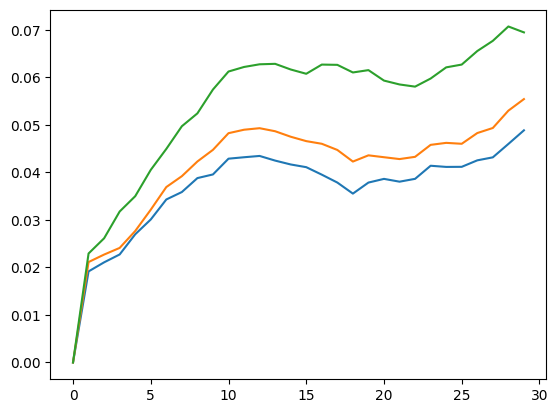

In [212]:
H_momentum = momentum_conservation(fake, dx=50/120)
H_mass = mass_conservation(fake, dx=50/120)
H_energy = energy_conservation(fake, dx=50/120, eta=6.0, gamma=0.1)

plt.plot(H_energy.mean(axis=0), label="energy")
plt.plot(H_momentum.mean(axis=0), label="momentum")
plt.plot(H_mass.mean(axis=0), label="mass")

In [268]:
values, indices = fake[:, 0, :].amax(axis=1).sort()
values, indices

(tensor([0.2000, 0.2065, 0.2147,  ..., 0.9791, 0.9799, 0.9805]),
 tensor([1414, 1493, 1236,  ...,  437,  747, 1054]))

In [269]:
fake_sorted = fake[indices]
fake_sorted.shape

torch.Size([1920, 30, 120])

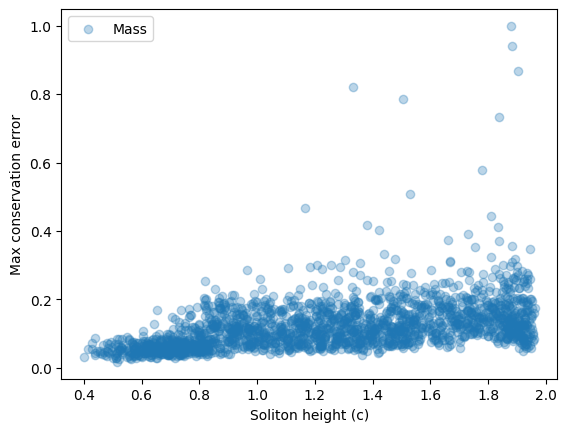

In [369]:
soliton_heights = 2*values

H_energy = mass_conservation(fake_sorted, dx=50/120); plt.scatter(soliton_heights, H_energy.amax(axis=1), label="Mass", alpha=0.3)
#H_energy = momentum_conservation(fake_sorted, dx=50/120); plt.scatter(soliton_heights, H_energy.amax(axis=1), label="Momentum", alpha=0.3)
#H_energy = energy_conservation(fake_sorted, dx=50/120, eta=6.0, gamma=1.0); plt.scatter(soliton_heights, H_energy.amax(axis=1), label="Energy", alpha=0.3)
plt.xlabel("Soliton height (c)")
plt.ylabel("Max conservation error")
plt.legend()

In [374]:
H_mass_ = 50/120 * fake_sorted.sum(axis=2)
H_mass_[0], H_mass_[-1]


(tensor([0.4333, 0.4350, 0.4376, 0.4537, 0.4584, 0.4458, 0.4372, 0.4324, 0.4397,
         0.4431, 0.4483, 0.4397, 0.4402, 0.4541, 0.4664, 0.4539, 0.4408, 0.4387,
         0.4425, 0.4219, 0.4131, 0.4163, 0.4288, 0.4334, 0.4437, 0.4533, 0.4494,
         0.4484, 0.4521, 0.4574]),
 tensor([2.0860, 2.0805, 2.0688, 2.0276, 1.9658, 1.9827, 2.0227, 2.0477, 1.9607,
         1.9519, 1.9112, 2.0132, 1.9290, 2.0064, 2.0286, 2.0565, 1.9969, 1.9834,
         2.0576, 2.0338, 2.0497, 1.9826, 2.0139, 2.0965, 1.9419, 2.0011, 1.9471,
         1.9222, 1.9256, 1.9762]))

In [366]:
soliton_heights

tensor([0.4000, 0.4131, 0.4294,  ..., 1.9582, 1.9599, 1.9610])

In [367]:

bins = np.linspace(0, len(soliton_heights) , 10, dtype=int)
H_error_bined = np.array([H_energy.amax(axis=1)[bins[i]:bins[i+1]].numpy() for i in range(len(bins)-1)])

/var/folders/wb/p5xwlpld3rbb00y719123mvr0000gn/T/ipykernel_902/3023639248.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  H_error_bined = np.array([H_energy.amax(axis=1)[bins[i]:bins[i+1]].numpy() for i in range(len(bins)-1)])


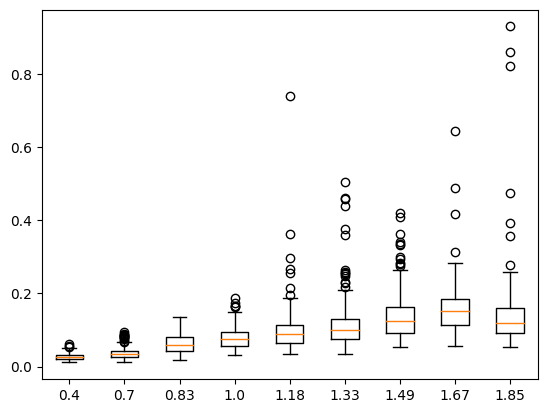

In [368]:
plt.boxplot(H_error_bined, labels=np.round(soliton_heights[bins[:-1]].numpy(), 2));

{'whiskers': [<matplotlib.lines.Line2D at 0x2ec44ee20>,
 'caps': [<matplotlib.lines.Line2D at 0x2ec47d3a0>,
 'boxes': [<matplotlib.lines.Line2D at 0x2ec44eb80>,
 'medians': [<matplotlib.lines.Line2D at 0x2e85a90a0>,
 'fliers': [<matplotlib.lines.Line2D at 0x2e8cc1b80>,
 'means': []}

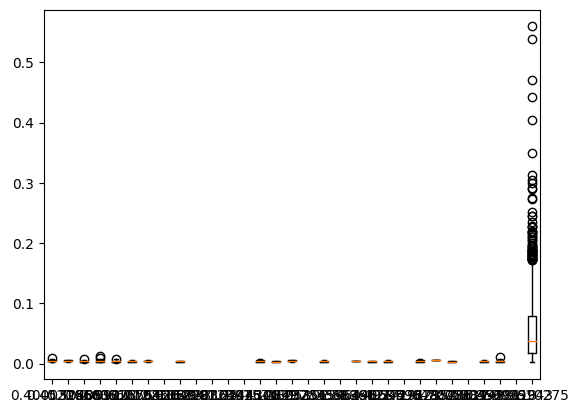

In [311]:

H_energy_max = H_energy.amax(axis=1)
binned_H_energy = [H_energy_max[temp[i]:temp[i+1]].numpy() for i in range(len(temp)-1)]
binned_H_energy
plt.boxplot(binned_H_energy, labels=bin_values)

In [277]:
bin_indices

array([ 54, 184, 230, 209, 183, 217, 206, 183, 174, 280])

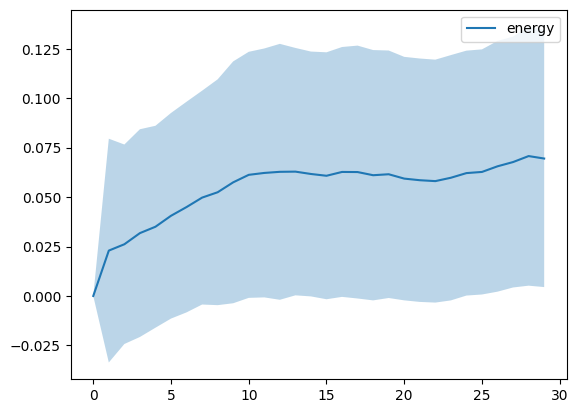

In [238]:
H_energy = mass_conservation(fake_sorted, dx=50/120)

# Plot the mean and standard deviation
mean = H_energy.mean(axis=0)
std = H_energy.std(axis=0)

plt.plot(mean, label="energy")
plt.fill_between(np.arange(len(mean)), mean-std, mean+std, alpha=0.3)

plt.legend()
plt.show()

## REGULAR PLOTS

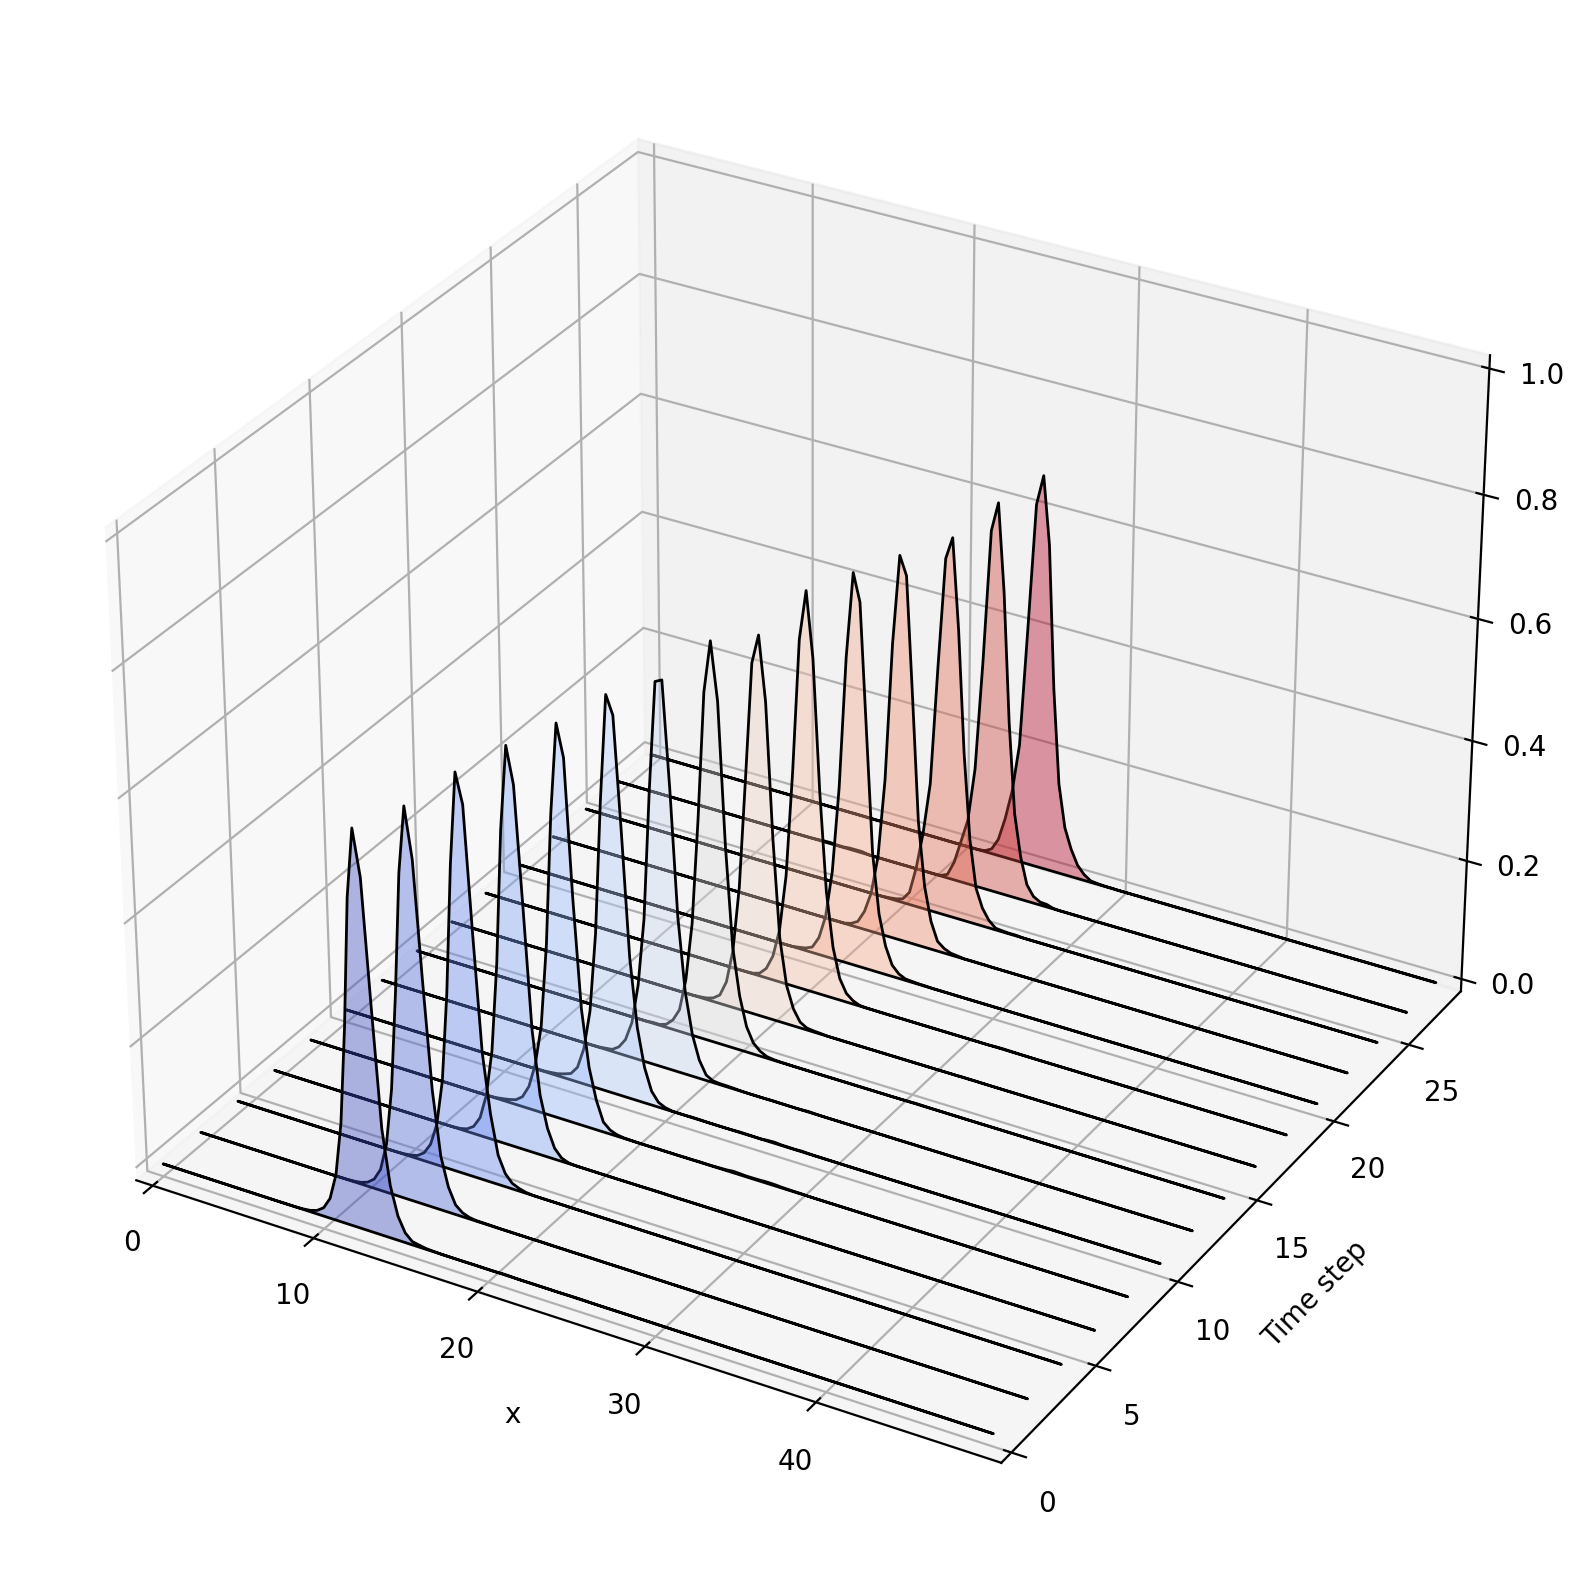

In [70]:
import numpy
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot
from matplotlib.collections import PolyCollection

def drawPropagation(sample, dt_step=1):

    T = numpy.linspace(0, 50-50/120, 120)
    z = numpy.arange(sample.shape[0])[::dt_step]#numpy.linspace(0, 10, 10)
    sample = sample[::dt_step]
    sx = T.size
    sy = z.size

    T = numpy.tile(T, (sy, 1))
    z = numpy.tile(z, (sx, 1)).T

    fig = pyplot.figure(figsize=(10,10), dpi=200)
    ax = fig.add_subplot(1,1,1, projection='3d')
    U = sample

    verts = []
    for i in range(T.shape[0]):
        verts.append(list(zip(T[i, :], U[i, :])))

    colors = pyplot.cm.coolwarm(numpy.linspace(0, 1, sy))

    # make the color transparent
    colors[:,3] = np.ones(sy) * 0.4 #numpy.linspace(0.1, 1, sy)

    poly = PolyCollection(verts, facecolors=colors, edgecolors=(0,0,0,1))
    ax.add_collection3d(poly, zs=z[:, 0], zdir='y')
    ax.set_xlim3d(numpy.min(T), numpy.max(T))
    ax.set_ylim3d(numpy.min(z), numpy.max(z))
    ax.set_zlim3d(0, 1)
    ax.set_xlabel('x')
    #ax.set_zlabel('Time step')
    ax.set_ylabel('Time step')

drawPropagation(fake[single_example_nr], dt_step=2)
pyplot.show()

/var/folders/wb/p5xwlpld3rbb00y719123mvr0000gn/T/ipykernel_902/172741451.py:35: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


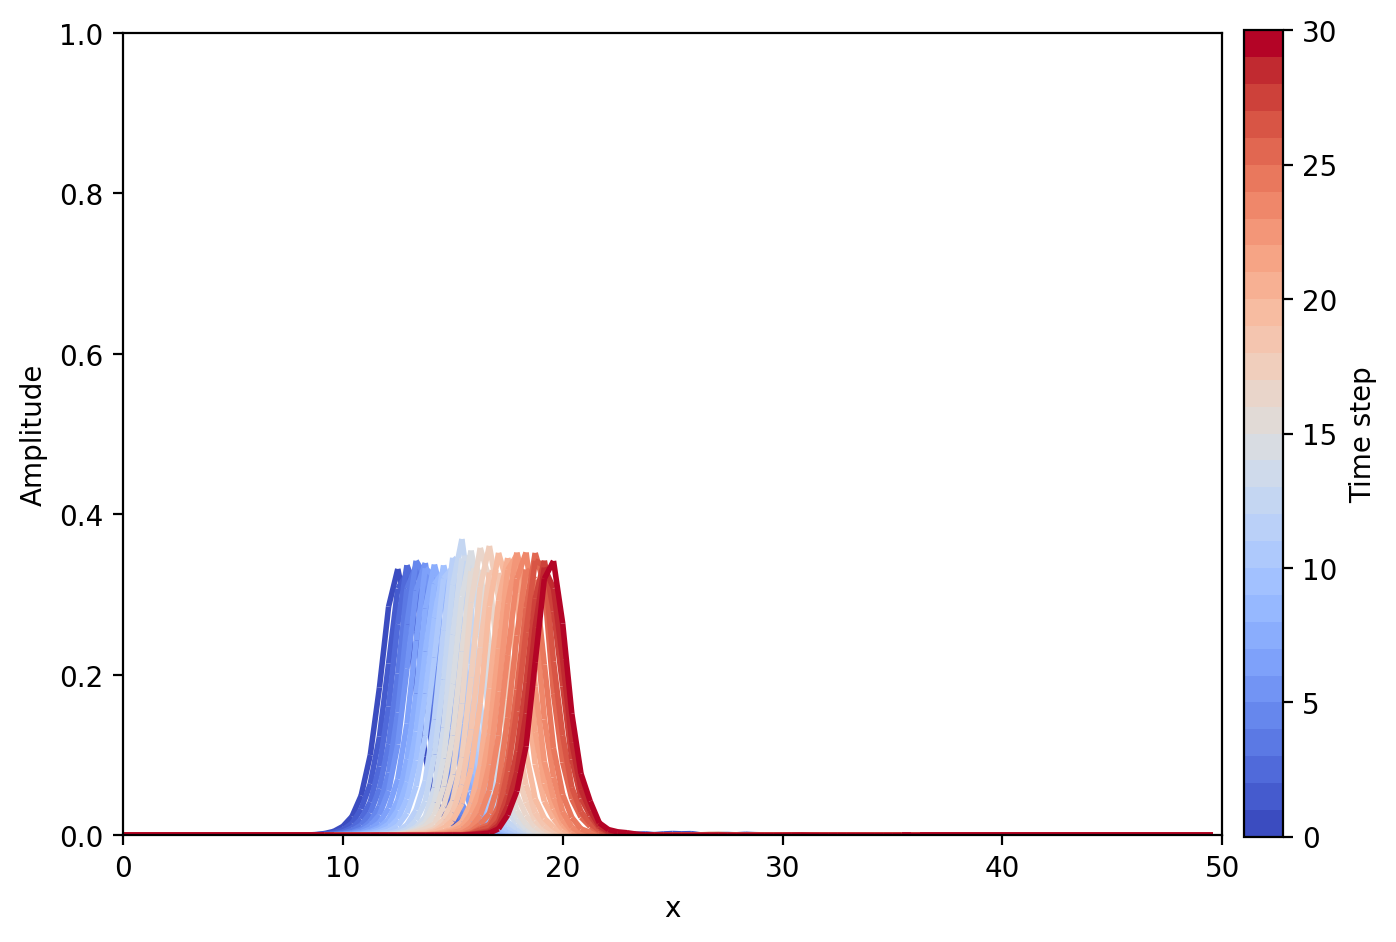

In [194]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot, cm
from matplotlib.collections import LineCollection
def plot_sample_oneplot(sample, dt_step=1):

    time_steps, x_dim = sample.shape
    # Define the time range and the frequencies of the waves
    x = np.linspace(0, 50-50/x_dim, x_dim)

    sample = sample[::dt_step]
    # Create LineCollection for each wave with a single color
    lines = []
    colors = cm.get_cmap('coolwarm', sample.shape[0])
    for i, wave in enumerate(sample):
        segments = [np.column_stack([x[i:i+2], wave[i:i+2]]) for i in range(len(x) - 1)]

        lc = LineCollection(segments, colors=colors(i), linewidth=2)
        lines.append(lc)

    # Plot all LineCollections on the same axes
    fig, ax = plt.subplots( dpi=200)
    ax.axis([0,50,0,1]) #set axis limits. This is [xlow, xhigh, ylow, yhigh]

    for lc in lines:
        line = ax.add_collection(lc)

    # Add labels and title
    plt.xlabel('x')
    plt.ylabel('Amplitude')
    # colorbar
    sm = plt.cm.ScalarMappable(cmap=colors, norm=plt.Normalize(vmin=0, vmax=time_steps))
    sm.set_array([])
    plt.colorbar(sm, label='Time step', cax=fig.add_axes([0.98, 0.12, 0.03, 0.84]))
    plt.tight_layout()
    # Show the plot
    plt.show()
plot_sample_oneplot(fake[9],dt_step=1)

/var/folders/wb/p5xwlpld3rbb00y719123mvr0000gn/T/ipykernel_902/1809950296.py:31: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


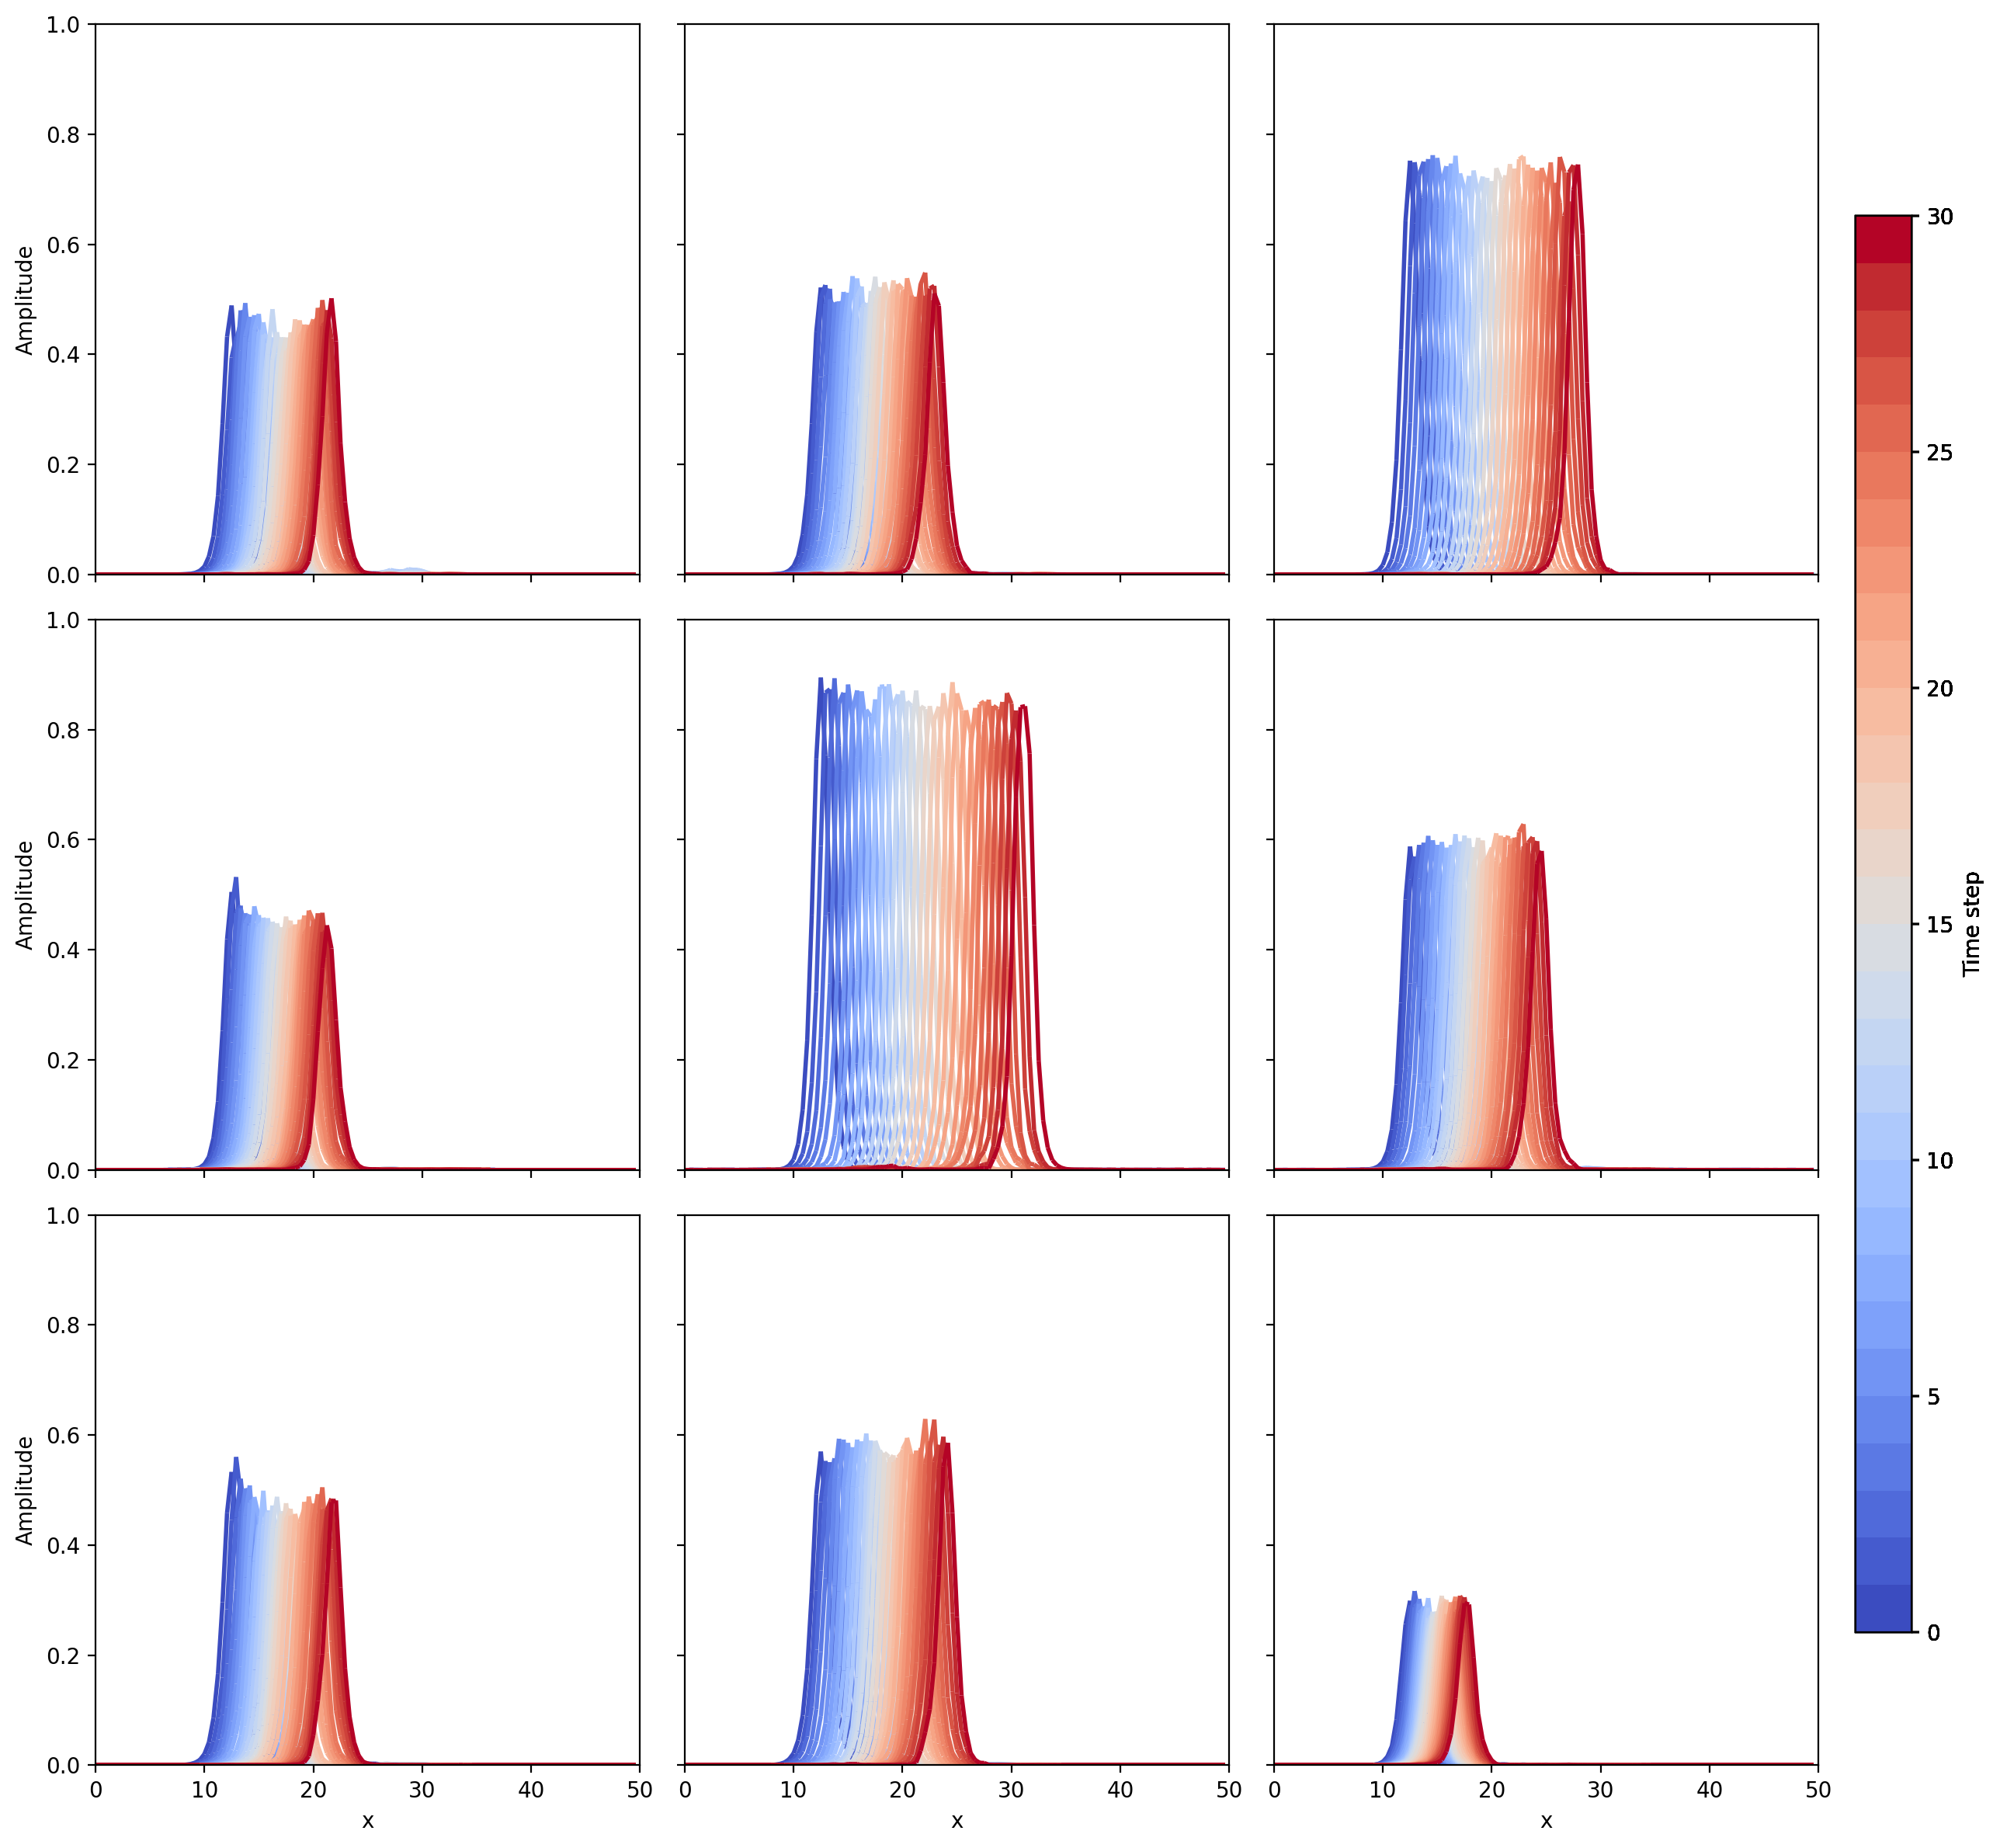

In [20]:
def plot_sample_batch(samples, dt_step=1):
    fig, axs = plt.subplots(3, 3, figsize=(12, 12), dpi=200, sharex=True, sharey=True)

    for i, sample in enumerate(samples):
        time_steps, x_dim = sample.shape
        x = np.linspace(0, 50-50/x_dim, x_dim)
        sample = sample[::dt_step]

        lines = []
        colors = cm.get_cmap('coolwarm', sample.shape[0])
        for j, wave in enumerate(sample):
            segments = [np.column_stack([x[k:k+2], wave[k:k+2]]) for k in range(len(x) - 1)]
            lc = LineCollection(segments, colors=colors(j), linewidth=2)
            lines.append(lc)

        row, col = divmod(i, 3)
        axs[row, col].axis([0,50,0,1])
        for lc in lines:
            axs[row, col].add_collection(lc)

        if col == 0:
            axs[row, col].set_ylabel('Amplitude')
        if row == 2:
            axs[row, col].set_xlabel('x')

        sm = plt.cm.ScalarMappable(cmap=colors, norm=plt.Normalize(vmin=0, vmax=time_steps))
        sm.set_array([])
        plt.colorbar(sm, label='Time step', cax=fig.add_axes([1.0, 0.12, 0.03, 0.76]))
        #plt.subplots_adjust(hspace=0, wspace=0)

    plt.tight_layout()
    plt.show()
plot_sample_batch(fake[9:18],dt_step=1)

# Soliton height distribution

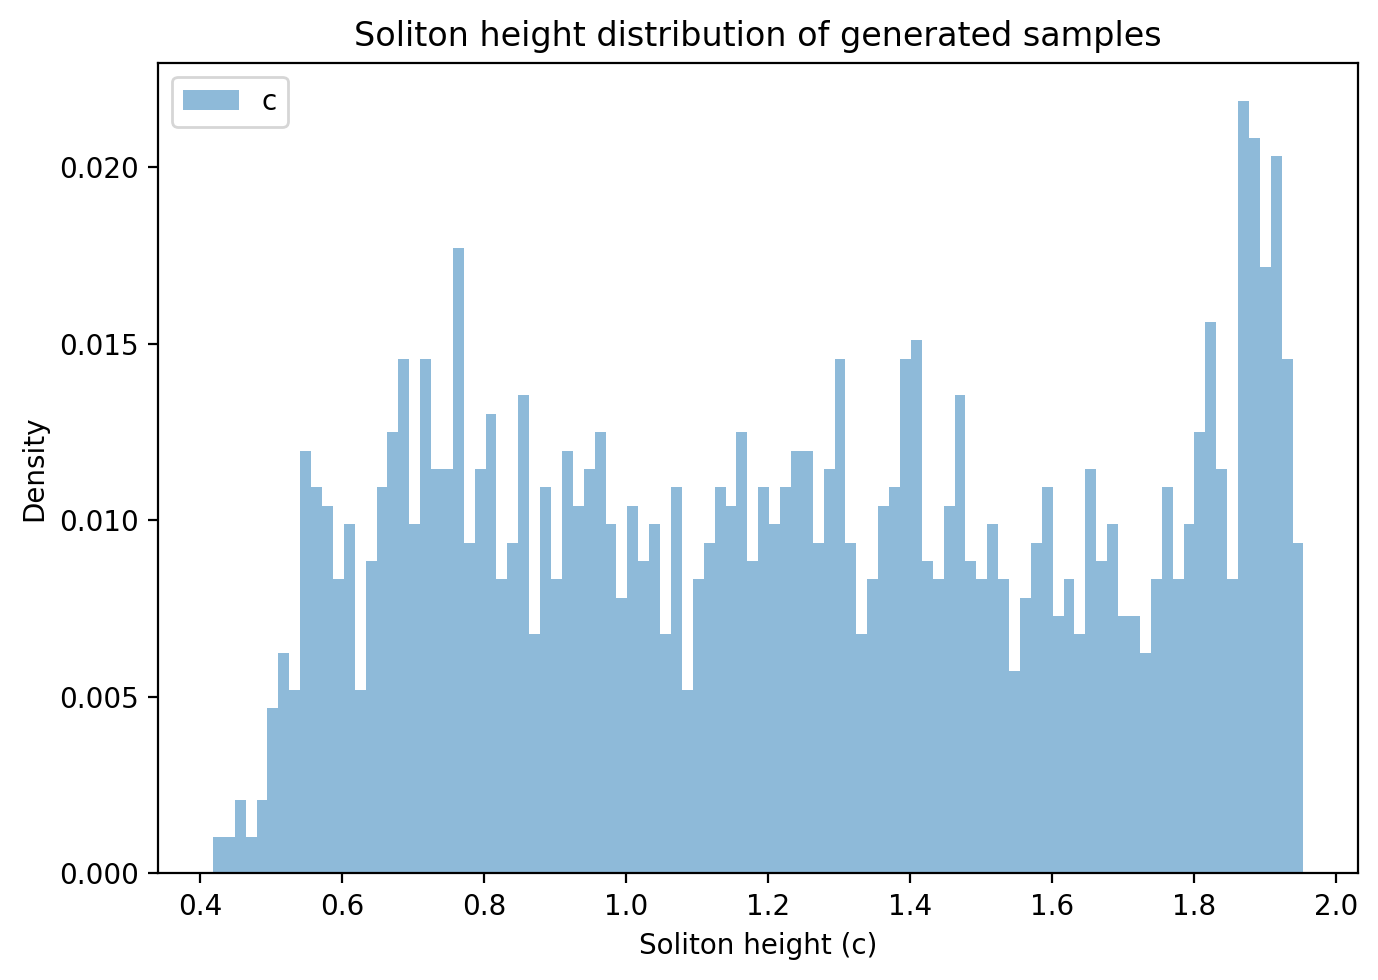

In [73]:
if "twosolitons" == params["dataset"]:
    d1, d2 = .3, .5
    _, t_res, x_res = fake.shape
    s1_max = int(x_res * d1)
    s2_max = int(x_res * d2)
    c_fake_s1 = fake[:, 0, s1_max].cpu()
    c_fake_s2 = fake[:, 0, s2_max].cpu()

    k1_est = np.sqrt(c_fake_s1 / 2)
    k2_est = np.sqrt(c_fake_s2 / 2)

    fig = plt.figure(figsize=(7, 5), dpi=200)
    plt.hist(k1_est, bins=100, weights=np.ones_like(k1_est) / len(k1_est), label=f"K$_1$", alpha=0.5)
    plt.hist(k2_est, bins=100, weights=np.ones_like(k1_est) / len(k1_est), label=f"K$_2$", alpha=0.5)
    plt.title("Soliton height distribution of generated samples")
    plt.xlabel("Soliton height (k)")
    plt.ylabel("Density")
    plt.legend()
    plt.tight_layout()
    #run["c_fake_distribution"].upload(fig)
    #plt.close(fig)


if "soliton" == params["dataset"]:
    c_fake = fake[:, 0, :].max(dim=1)[0]

    fig = plt.figure(figsize=(7, 5), dpi=200)
    plt.hist(2. * c_fake, bins=100, weights=np.ones_like(c_fake) / len(c_fake), label="c", alpha=0.5)
    plt.title("Soliton height distribution of generated samples")
    plt.xlabel("Soliton height (c)")
    plt.ylabel("Density")
    plt.legend()
    plt.tight_layout()
    #run["c_fake_distribution"].upload(fig)
    #plt.close(fig)

# PCA TEST

In [136]:
# Two Colliding Solitons
from utils import DatasetTwoCollidingSolitons
real_data = DatasetTwoCollidingSolitons(file_dir="datasets/", dx=120, dt=30, num_samples=params["trainset_size"])

RAW data: (1000, 360, 360), MB: 518.4
	Downsampled:(1000, 30, 120), MB: 14.4
RAW data: (1000, 360, 360), MB: 518.4
	Downsampled:(1000, 30, 120), MB: 14.4
RAW data: (1000, 360, 360), MB: 518.4
	Downsampled:(1000, 30, 120), MB: 14.4
Concatenated data with shape (3000, 30, 120) and size: 43.2 MB


In [125]:
# Single Soliton
from utils import DatasetSoliton
real_data = DatasetSoliton(params["trainset_size"], P=50, t_range=[0,10], c_range=[0.5, 2], spatial_len=120, t_steps=30)

prep_data.shape: (1000, 3600)
first item of prep_data: [2.6473050e-05 3.5460944e-05 4.7500034e-05 ... 7.4484582e-05 6.6417124e-05
 4.6623620e-05]


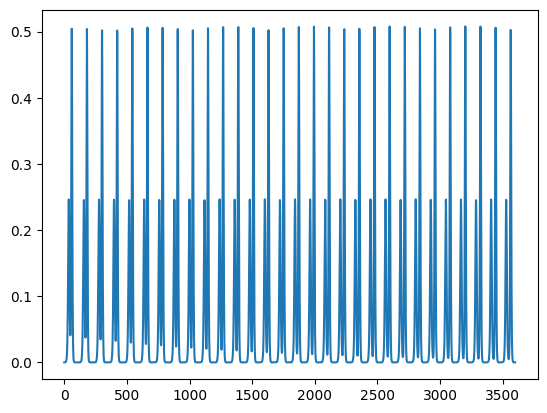

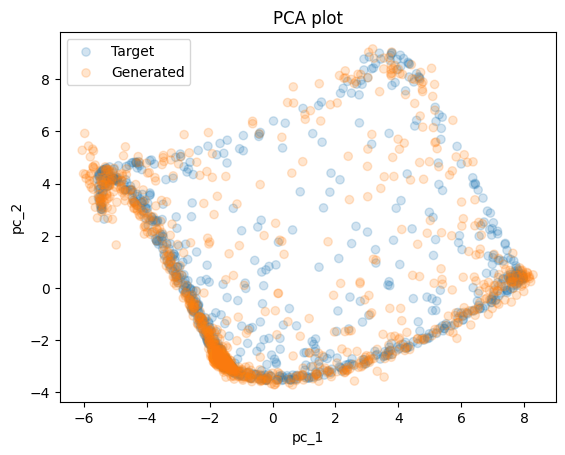

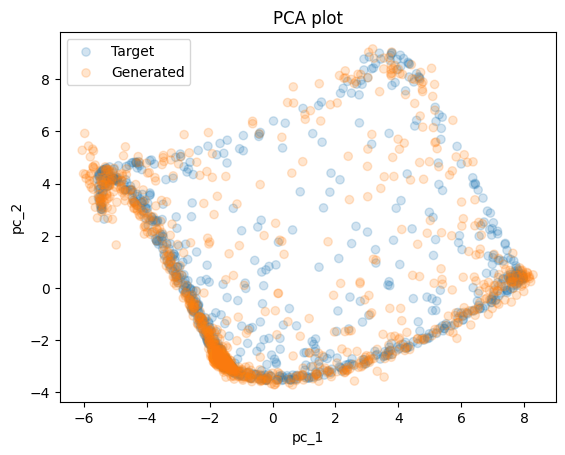

In [139]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import umap

def visualization(ori_data, generated_data, analysis):
    """Using PCA or tSNE for generated and original data visualization.

    Args:
      - ori_data: original data
      - generated_data: generated synthetic data
      - analysis: tsne or pca
    """
    # Analysis sample size (for faster computation)
    anal_sample_no = min([1000, len(ori_data)])
    idx = np.random.permutation(len(ori_data))[:anal_sample_no]

    # Data preprocessing
    ori_data = np.asarray(ori_data)[idx]
    generated_data = np.asarray(generated_data)[idx]

    prep_data = np.reshape(ori_data, [1000, 30* 120]) #np.mean(ori_data, axis=2)
    prep_data_hat = np.reshape(generated_data, [1000, 30*120])#np.mean(generated_data, axis=2)
    #prep_data = ori_data[:, -1, :]
    #prep_data_hat = generated_data[:, -1, :]
    anal_sample_no = prep_data.shape[0]


    print(f"prep_data.shape: {prep_data.shape}")
    print(f"first item of prep_data: {prep_data[0]}")
    plt.plot(prep_data[0])
    plt.show()

    # Visualization parameter
    colors = ["tab:blue" for i in range(anal_sample_no)] + ["tab:orange" for i in range(anal_sample_no)]

    if analysis == 'pca':
        # PCA Analysis
        pca = PCA(n_components=2)
        pca.fit(prep_data)
        pca_results = pca.transform(prep_data)
        pca_hat_results = pca.transform(prep_data_hat)

        # Plotting
        f, ax = plt.subplots(1)
        plt.scatter(pca_results[:, 0], pca_results[:, 1],
                    c=colors[:anal_sample_no], alpha=0.2, label="Target")
        plt.scatter(pca_hat_results[:, 0], pca_hat_results[:, 1],
                    c=colors[anal_sample_no:], alpha=0.2, label="Generated")

        ax.legend()
        plt.title('PCA plot')
        plt.xlabel('pc_1')
        plt.ylabel('pc_2')
        # plt.show()
        return f

    elif analysis == 'tsne':

        # Do t-SNE Analysis together
        prep_data_final = np.concatenate((prep_data, prep_data_hat), axis=0)

        # TSNE anlaysis
        tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300)
        tsne_results = tsne.fit_transform(prep_data_final)

        # Plotting
        f, ax = plt.subplots(1)

        plt.scatter(tsne_results[:anal_sample_no, 0], tsne_results[:anal_sample_no, 1],
                    c=colors[:anal_sample_no], alpha=0.2, label="Target")
        plt.scatter(tsne_results[anal_sample_no:, 0], tsne_results[anal_sample_no:, 1],
                    c=colors[anal_sample_no:], alpha=0.2, label="Generated")

        ax.legend()

        plt.title('t-SNE plot')
        plt.xlabel('tsne_1')
        plt.ylabel('tsne_2')
        # plt.show()
        return f
    elif analysis == 'umap':

        prep_data_final = np.concatenate((prep_data, prep_data_hat), axis=0)
        reducer = umap.UMAP()
        embedding = reducer.fit_transform(prep_data_final)
        f, ax = plt.subplots(1)

        plt.scatter(embedding[:anal_sample_no, 0], embedding[:anal_sample_no, 1],
                    c=colors[:anal_sample_no], alpha=0.2, label="Target")
        plt.scatter(embedding[anal_sample_no:, 0], embedding[anal_sample_no:, 1],
                    c=colors[anal_sample_no:], alpha=0.2, label="Generated")

        ax.legend()

        plt.title('UMAP plot')
        plt.xlabel('umap_1')
        plt.ylabel('umap_2')
        # plt.show()
        return f

visualization(real_data[:], fake, "pca")

In [ ]:
plt.plot()

In [140]:
from metrics import sw_approx

In [141]:
# Single Soliton
from utils import DatasetSoliton

In [156]:
sw_samples = np.zeros(1000)
for i in range(1000):
    real_data1 = DatasetSoliton(params["trainset_size"], P=50, t_range=[0,10], c_range=[0.5, 2], spatial_len=120, t_steps=30)
    real_data2 = DatasetSoliton(params["trainset_size"], P=50, t_range=[0,10], c_range=[0.5, 2], spatial_len=120, t_steps=30)
    sw_samples[i] = sw_approx(real_data1.data.view(params["trainset_size"] * 30, -1), real_data2.data.view(params["trainset_size"] * 30, -1))

{'whiskers': [<matplotlib.lines.Line2D at 0x2ab71d910>,
 'caps': [<matplotlib.lines.Line2D at 0x2ab70b7f0>,
 'boxes': [<matplotlib.lines.Line2D at 0x2ab71da60>],
 'medians': [<matplotlib.lines.Line2D at 0x2ab70bb80>],
 'fliers': [<matplotlib.lines.Line2D at 0x2ac143c70>],
 'means': [<matplotlib.lines.Line2D at 0x2ab70baf0>]}

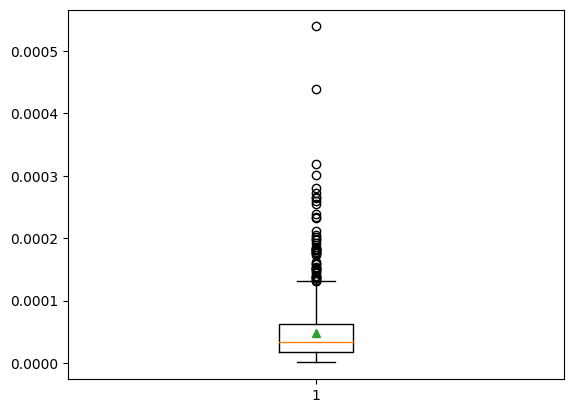

In [157]:
plt.boxplot(sw_samples, showmeans=True)

In [165]:
5.e-5 - 0.0005

-0.00045

In [163]:
np.median(sw_samples), sw_samples.std()

(3.421402652747929e-05, 4.839241661657585e-05)

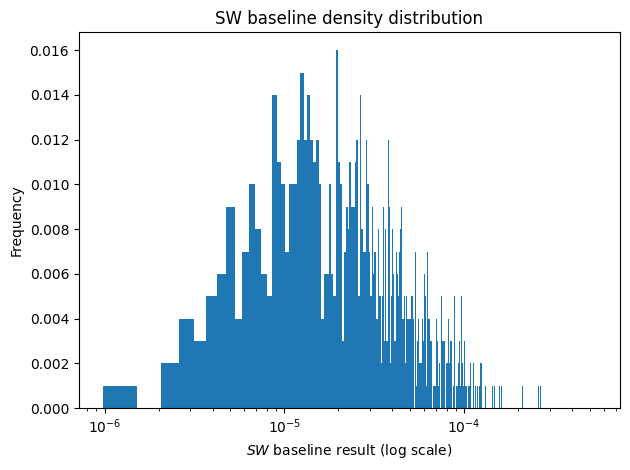

In [174]:
plt.hist(sw_samples, bins=1000, weights=np.ones(len(sw_samples)) / len(sw_samples))
plt.xlabel(f"$SW$ baseline result (log scale)")
plt.xscale("log")
plt.ylabel("Frequency")
plt.title("SW baseline density distribution")
plt.tight_layout()